# Phase 5: Feature Engineering & Preprocessing Pipeline

This notebook demonstrates the transition from raw historical data to a optimized, model-ready dataset. 

### Key Objectives:
1. **Address High Cardinality**: Remove unique identifiers.
2. **Handle Linear Dependency**: Solve the '24-Hour Law' hurdle.
3. **Interaction Ratios**: Create domain-specific features (e.g., Academic Pressure).
4. **Ordinal Mapping**: Pre-process targets for classification.
5. **Normalization**: Scaling features for numerical stability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Set plotting style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

# Load data
raw_df = pd.read_csv('../data/raw.csv')
print(f"Raw Shape: {raw_df.shape}")
raw_df.head()

Raw Shape: (2000, 8)


,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


## 1. Dropping High Cardinality
As identified in the audit, `Student_ID` is a unique key per row. It provides no predictive power and encourages overfitting.

In [2]:
df = raw_df.drop(columns=['Student_ID'])
print(f"New Shape: {df.shape}")

New Shape: (2000, 7)


## 2. Feature Engineering: Interaction Ratios
Raw hours are informative, but the *ratio* of stress-inducing activities (Study) vs. recovery activities (Sleep/Social) often reveals more about student risk.

In [3]:
# Academic Pressure Index: Ratio of study to rest hours
df['Academic_Pressure_Index'] = df['Study_Hours_Per_Day'] / (df['Social_Hours_Per_Day'] + df['Sleep_Hours_Per_Day'] + 1e-5)

# Wellness Ratio: Balancing physical and sleep relative to study
df['Wellness_Ratio'] = (df['Physical_Activity_Hours_Per_Day'] + df['Sleep_Hours_Per_Day']) / (df['Study_Hours_Per_Day'] + 1e-5)

# GPA Efficiency: Quality of GPA per study hour invested
df['GPA_Efficiency'] = df['GPA'] / (df['Study_Hours_Per_Day'] + 1e-5)

display(df[['Academic_Pressure_Index', 'Wellness_Ratio', 'GPA_Efficiency']].describe())

,Academic_Pressure_Index,Wellness_Ratio,GPA_Efficiency
count,2000.000000,2000.000000,2000.000000
mean,0.765723,1.676098,0.426955
std,0.224616,0.573601,0.061412
min,0.342466,0.575757,0.298936
25%,0.595135,1.226905,0.378491
50%,0.745190,1.573331,0.418592
75%,0.906322,2.040278,0.468749
max,1.799997,3.607836,0.675470


## 3. Resolving Linear Dependency (The 24-Hour Law)
We drop `Extracurricular_Hours_Per_Day` to ensure the remaining features are not perfectly linearly dependent (Sum=24), which would prevent many models from converging.

In [4]:
df = df.drop(columns=['Extracurricular_Hours_Per_Day'])
print("Dropped redundant hour feature. Collinearity risk mitigated.")

Dropped redundant hour feature. Collinearity risk mitigated.


## 4. Visualizing New Feature Distributions by Stress Level

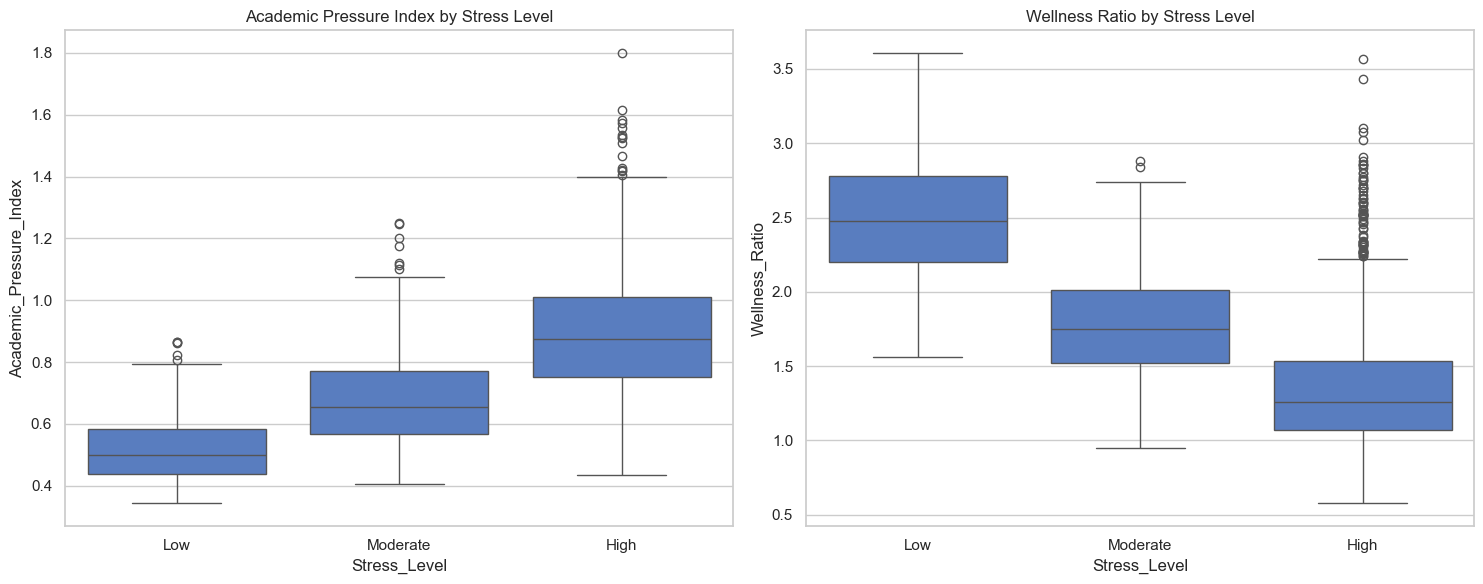

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=df, x='Stress_Level', y='Academic_Pressure_Index', ax=axes[0], order=['Low', 'Moderate', 'High'])
axes[0].set_title('Academic Pressure Index by Stress Level')

sns.boxplot(data=df, x='Stress_Level', y='Wellness_Ratio', ax=axes[1], order=['Low', 'Moderate', 'High'])
axes[1].set_title('Wellness Ratio by Stress Level')

plt.tight_layout()
plt.show()

## 5. Ordinal Encoding & Normalization
Finally, we map the target to numbers and scale all features to a [0, 1] range.

In [6]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# Encode Target
stress_order = ['Low', 'Moderate', 'High']
encoder = OrdinalEncoder(categories=[stress_order])
df['Stress_Level'] = encoder.fit_transform(df[['Stress_Level']]).astype(int)

# Scale Features
scaler = MinMaxScaler()
num_cols = df.columns.drop('Stress_Level')
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Preprocessing Complete.")
df.head()

Preprocessing Complete.


,Study_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level,Academic_Pressure_Index,Wellness_Ratio,GPA_Efficiency
0,0.38,0.74,0.466667,0.138462,0.426136,1,0.176692,0.311991,0.356931
1,0.06,0.60,0.700000,0.230769,0.289773,0,0.063093,0.494615,0.584093
2,0.02,0.84,0.200000,0.353846,0.244318,0,0.101486,0.702528,0.596473
3,0.30,0.44,0.283333,0.500000,0.363636,1,0.266115,0.505241,0.382808
4,0.62,0.30,0.366667,0.507692,0.721591,2,0.403812,0.343502,0.356931
